In [1]:
# Cell 1: Setup and Imports
import os
import shutil
import random
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
import torch
from ultralytics import YOLO
import logging
from collections import Counter
from sklearn.model_selection import train_test_split

# Set up logging for debugging and monitoring
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
logger.info("Random seeds set for reproducibility.")

/home/r0jin/projects/EnigmaAI/enigmaAI_env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-03-30 14:30:55,573 - INFO - Random seeds set for reproducibility.


In [2]:
# Define directory structure
base_dir = Path('../datasets').resolve()
combined_images_dir = base_dir / 'combined_dataset' / 'images'
combined_labels_dir = base_dir / 'combined_dataset' / 'labels'
subset_dir = base_dir / 'subset_dataset2'
subset_images_dir = subset_dir / 'images'
subset_labels_dir = subset_dir / 'labels'
balanced_dir = base_dir / 'balanced_subset2'
balanced_images_dir = balanced_dir / 'images'
balanced_labels_dir = balanced_dir / 'labels'
yolo_dir = Path('../yolo_subset2').resolve()

In [3]:
# Create necessary directories
for dir_path in [subset_images_dir, subset_labels_dir, balanced_images_dir, balanced_labels_dir,
                 yolo_dir / 'images' / 'train', yolo_dir / 'images' / 'val',
                 yolo_dir / 'labels' / 'train', yolo_dir / 'labels' / 'val']:
    dir_path.mkdir(parents=True, exist_ok=True)
    logger.debug(f"Created directory: {dir_path}")

# Log environment details
logger.info(f"Albumentations version: {A.__version__}")
logger.info(f"Torch version: {torch.__version__}")
logger.info(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")

2025-03-30 14:32:18,888 - INFO - Albumentations version: 1.4.21
2025-03-30 14:32:18,889 - INFO - Torch version: 2.5.1+cu121
2025-03-30 14:32:18,889 - INFO - CUDA available: True
2025-03-30 14:32:18,912 - INFO - GPU: NVIDIA GeForce RTX 2070 with Max-Q Design


In [4]:
# Cell 2: Define Classes and Utility Functions
selected_classes = ['door', 'table', 'openedDoor', 'chair', 'pole', 'bike', 'truck', 'car', 'dog', 'bus']
class_to_id = {cls: idx for idx, cls in enumerate(selected_classes)}
overrepresented_classes = {4, 5, 7}  # pole, bike, car
underrepresented_classes = {0, 1, 2, 3, 6, 8, 9}  # door, table, openedDoor, chair, truck, dog, bus

def get_class_counts(labels_dir):
    """Calculate instance counts per class in the dataset."""
    counts = Counter()
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(float(line.split()[0]))
                    counts[class_id] += 1
    return counts

def visualize_image(image_path, label_path):
    """Visualize an image with its bounding boxes."""
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    try:
                        cls_id = int(float(parts[0]))
                        x, y, w_box, h_box = map(float, parts[1:])
                        xmin = int((x - w_box / 2) * w)
                        xmax = int((x + w_box / 2) * w)
                        ymin = int((y - h_box / 2) * h)
                        ymax = int((y + h_box / 2) * h)
                        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                        cv2.putText(img, selected_classes[cls_id], (xmin, ymin - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    except ValueError as e:
                        logger.error(f"Invalid data in {label_path}: {line.strip()} - {e}")
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

2025-03-30 14:32:53,850 - INFO - Created subset with 919 images.


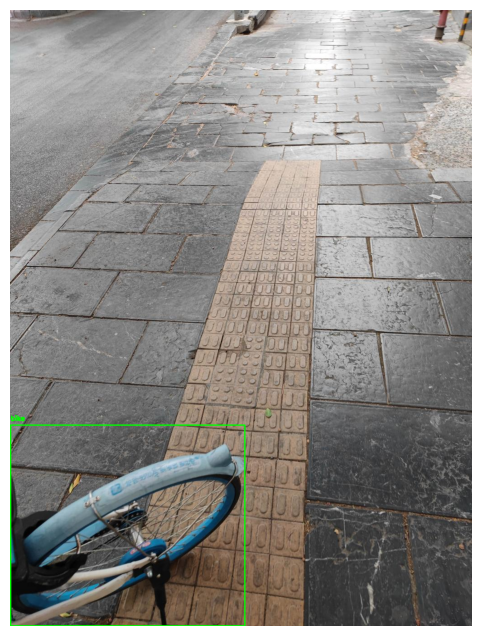

In [5]:
# Cell 3: Create Subset Dataset
def select_subset():
    """Select a subset of images with up to 100 images per class."""
    images_per_class = {cls: [] for cls in selected_classes}
    for label_file in combined_labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            classes = {int(line.split()[0]) for line in f if line.strip()}
        stem = label_file.stem
        for cls in classes:
            images_per_class[selected_classes[cls]].append(stem)
    
    subset_images = set()
    for cls, images in images_per_class.items():
        sample_size = min(100, len(images))
        if images:
            subset_images.update(random.sample(images, sample_size))
    
    for stem in subset_images:
        found = False
        for ext in ['.jpg', '.jpeg', '.png']:
            img_path = combined_images_dir / (stem + ext)
            if img_path.exists():
                found = True
                break
        if not found:
            logger.warning(f"Image not found for {stem}, skipping.")
            continue
        lbl_src = combined_labels_dir / (stem + '.txt')
        if not lbl_src.exists():
            logger.warning(f"Label not found for {stem}, skipping.")
            continue
        shutil.copy(img_path, subset_images_dir / img_path.name)
        shutil.copy(lbl_src, subset_labels_dir / lbl_src.name)

select_subset()
logger.info(f"Created subset with {len(list(subset_images_dir.glob('*')))} images.")
sample_img = list(subset_images_dir.glob('*.jpg'))[0]
sample_lbl = subset_labels_dir / (sample_img.stem + '.txt')
visualize_image(sample_img, sample_lbl)

Processing subset:  95%|█████████▍| 806/852 [00:20<00:01, 28.03it/s]/home/r0jin/projects/EnigmaAI/enigmaAI_env/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)
Processing subset: 100%|██████████| 852/852 [00:21<00:00, 39.95it/s]
2025-03-30 14:34:54,349 - INFO - Balanced subset created with 2152 images.


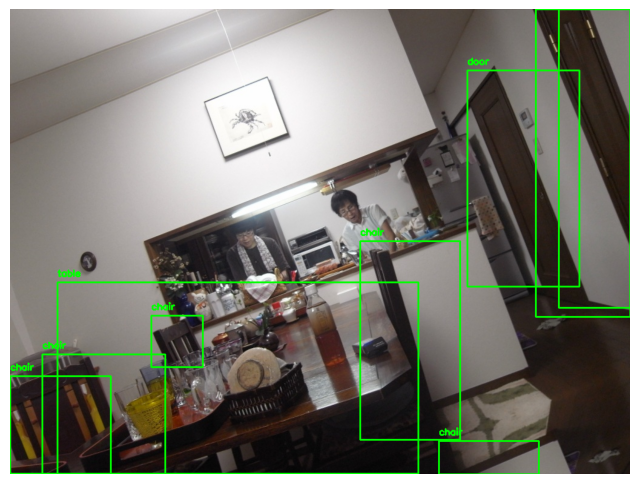

2025-03-30 14:34:55,464 - INFO - YOLO dataset prepared.


In [7]:
# Cell 4: Augmentation Pipeline and Processing
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, border_mode=cv2.BORDER_REFLECT, p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_id'], min_visibility=0.1, clip=True))

def mask_overrepresented(image_path, label_path):
    """Mask overrepresented class regions in the image, return image and underrepresented labels."""
    img = cv2.imread(str(image_path))
    h, w = img.shape[:2]
    with open(label_path, 'r') as f:
        lines = f.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        cls_id = int(parts[0])
        if cls_id in overrepresented_classes:
            x, y, w_box, h_box = map(float, parts[1:])
            xmin = int(max(0, (x - w_box / 2) * w))
            xmax = int(min(w, (x + w_box / 2) * w))
            ymin = int(max(0, (y - h_box / 2) * h))
            ymax = int(min(h, (y + h_box / 2) * h))
            img[ymin:ymax, xmin:xmax] = 0  # Mask by setting to black
        else:
            new_lines.append(line)
    return img, new_lines

def augment_image(image_file, label_file, n_aug=2):
    """Augment images with underrepresented classes; copy images with only overrepresented classes."""
    with open(label_file, 'r') as f:
        lines = [l for l in f if l.strip()]
    classes = {int(l.split()[0]) for l in lines}
    has_under = bool(classes & underrepresented_classes)
    has_over = bool(classes & overrepresented_classes)
    
    if has_under:
        # Handle images with underrepresented classes
        if has_over:
            img, labels = mask_overrepresented(image_file, label_file)
        else:
            img = cv2.imread(str(image_file))
            labels = lines
        
        # Save original image (masked if overrepresented present) with only underrepresented labels
        cv2.imwrite(str(balanced_images_dir / image_file.name), img)
        with open(balanced_labels_dir / (image_file.stem + '.txt'), 'w') as f:
            for line in labels:
                if int(line.split()[0]) in underrepresented_classes:
                    f.write(line)
        
        # Perform augmentation
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bboxes = [list(map(float, l.split()[1:])) for l in labels if int(l.split()[0]) in underrepresented_classes]
        cats = [int(l.split()[0]) for l in labels if int(l.split()[0]) in underrepresented_classes]
        for i in range(n_aug):
            try:
                aug = augmentation(image=img_rgb, bboxes=bboxes, category_id=cats)
                aug_img = cv2.cvtColor(aug['image'], cv2.COLOR_RGB2BGR)
                aug_bboxes = aug['bboxes']
                aug_cats = aug['category_id']
                valid_bboxes = []
                valid_cats = []
                for bbox, cat in zip(aug_bboxes, aug_cats):
                    x, y, w, h = map(lambda v: np.clip(v, 0, 1), bbox)
                    if w > 0 and h > 0:
                        valid_bboxes.append([x, y, w, h])
                        valid_cats.append(cat)
                if valid_bboxes:
                    aug_path = balanced_images_dir / f"{image_file.stem}_aug_{i}.jpg"
                    lbl_path = balanced_labels_dir / f"{image_file.stem}_aug_{i}.txt"
                    cv2.imwrite(str(aug_path), aug_img)
                    with open(lbl_path, 'w') as f:
                        for bbox, cat in zip(valid_bboxes, valid_cats):
                            f.write(f"{cat} {' '.join(map(str, bbox))}\n")
            except Exception as e:
                logger.error(f"Augmentation failed for {image_file}, iter {i}: {e}")
    else:
        # Handle images with only overrepresented classes: copy without augmentation
        shutil.copy(image_file, balanced_images_dir / image_file.name)
        shutil.copy(label_file, balanced_labels_dir / label_file.name)

# Process all images in the subset
for img in tqdm(list(subset_images_dir.glob('*.jpg')), desc="Processing subset"):
    lbl = subset_labels_dir / (img.stem + '.txt')
    if lbl.exists():
        augment_image(img, lbl)

logger.info(f"Balanced subset created with {len(list(balanced_images_dir.glob('*.jpg')))} images.")
visualize_image(list(balanced_images_dir.glob('*aug_0.jpg'))[0],
                balanced_labels_dir / (list(balanced_images_dir.glob('*aug_0.jpg'))[0].stem + '.txt'))

# Cell 5: Prepare YOLO Dataset
images = list(balanced_images_dir.glob('*.jpg'))
train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

for split, img_dir, lbl_dir in [('train', yolo_dir / 'images' / 'train', yolo_dir / 'labels' / 'train'),
                                ('val', yolo_dir / 'images' / 'val', yolo_dir / 'labels' / 'val')]:
    imgs = train_imgs if split == 'train' else val_imgs
    for img in imgs:
        lbl = balanced_labels_dir / (img.stem + '.txt')
        shutil.copy(img, img_dir / img.name)
        if lbl.exists():
            shutil.copy(lbl, lbl_dir / lbl.name)

data_yaml = f"""
train: {yolo_dir / 'images' / 'train'}
val: {yolo_dir / 'images' / 'val'}
nc: {len(selected_classes)}
names: {selected_classes}
"""
with open(yolo_dir / 'data.yaml', 'w') as f:
    f.write(data_yaml)
logger.info("YOLO dataset prepared.")



In [10]:
# Cell 6: Train YOLOv8s
model = YOLO('yolov8s.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

def check_nan(trainer):
    """Callback to detect NaN gradients during training."""
    for name, param in trainer.model.named_parameters():
        if param.grad is not None and torch.isnan(param.grad).any():
            logger.error(f"NaN in gradients of {name} at epoch {trainer.epoch}")
            raise ValueError("NaN detected")

model.add_callback('on_before_optimizer_step', check_nan)

results = model.train(
    data=str(yolo_dir / 'data.yaml'),
    epochs=50,
    batch=8,
    imgsz=640,
    device=device,
    patience=5,
    lr0=1e-5,
    augment=False,  # Offline augmentation already applied
    save=True,
    project='runs/train',
    name='subset_test4',
    verbose=True
)

logger.info("Training completed.")

Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7959MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/home/r0jin/projects/EnigmaAI/yolo_subset2/data.yaml, epochs=50, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=runs/train, name=subset_test4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

train: Scanning /home/r0jin/projects/EnigmaAI/yolo_subset2/labels/train.cache... 2018 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2018/2018 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/r0jin/projects/EnigmaAI/yolo_subset2/labels/val.cache... 727 images, 0 backgrounds, 0 corrupt: 100%|██████████| 727/727 [00:00<?, ?it/s]


Plotting labels to runs/train/subset_test4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/subset_test4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.49G      1.561      3.172      1.454          5        640: 100%|██████████| 253/253 [00:39<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.73it/s]


                   all        727       1916       0.49      0.389      0.391      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.25G      1.557      2.199       1.48          5        640: 100%|██████████| 253/253 [00:38<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.79it/s]


                   all        727       1916      0.412      0.401      0.366      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.25G      1.629       2.21      1.531         11        640: 100%|██████████| 253/253 [00:37<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.72it/s]


                   all        727       1916      0.436      0.389      0.354      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.25G      1.613        2.2       1.53          5        640: 100%|██████████| 253/253 [00:38<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.89it/s]


                   all        727       1916      0.463      0.427       0.41      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.25G      1.589      2.066       1.51         16        640: 100%|██████████| 253/253 [00:38<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.21it/s]

                   all        727       1916      0.496      0.439       0.45      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.25G      1.541      1.977      1.474          8        640: 100%|██████████| 253/253 [00:40<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.28it/s]

                   all        727       1916      0.571      0.451      0.482      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.25G      1.506      1.882      1.453          5        640: 100%|██████████| 253/253 [00:39<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.94it/s]


                   all        727       1916      0.567      0.513      0.529      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.25G      1.452      1.758      1.403         17        640: 100%|██████████| 253/253 [00:35<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.04it/s]


                   all        727       1916      0.568       0.54      0.561      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.25G      1.439      1.699      1.391         10        640: 100%|██████████| 253/253 [00:36<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.18it/s]


                   all        727       1916      0.624      0.531      0.578      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.25G      1.416      1.631      1.386         17        640: 100%|██████████| 253/253 [00:36<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.18it/s]


                   all        727       1916      0.702      0.555       0.62      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.25G      1.387      1.568      1.364          9        640: 100%|██████████| 253/253 [00:36<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.12it/s]


                   all        727       1916      0.712      0.568      0.637      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.25G      1.353      1.526      1.359         12        640: 100%|██████████| 253/253 [00:37<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.05it/s]


                   all        727       1916       0.68       0.61      0.668      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.25G      1.325      1.441       1.32         17        640: 100%|██████████| 253/253 [00:36<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.07it/s]


                   all        727       1916      0.717      0.603      0.676       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.25G       1.31      1.447      1.315         11        640: 100%|██████████| 253/253 [00:37<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.08it/s]


                   all        727       1916      0.704      0.642        0.7      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.25G      1.289      1.347      1.292         15        640: 100%|██████████| 253/253 [00:36<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.18it/s]


                   all        727       1916      0.746      0.633       0.72      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.25G      1.241      1.301       1.28         10        640: 100%|██████████| 253/253 [00:37<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.90it/s]


                   all        727       1916      0.769       0.65      0.734      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.25G      1.229      1.253      1.261          5        640: 100%|██████████| 253/253 [00:36<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.10it/s]

                   all        727       1916      0.792       0.66      0.742      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.25G      1.228      1.239      1.257          8        640: 100%|██████████| 253/253 [00:37<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.33it/s]


                   all        727       1916      0.791      0.678      0.754      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.25G       1.18      1.172      1.231          7        640: 100%|██████████| 253/253 [00:36<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.15it/s]


                   all        727       1916      0.815      0.681      0.764      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.25G      1.172      1.171       1.22          8        640: 100%|██████████| 253/253 [00:37<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.98it/s]


                   all        727       1916      0.809      0.705      0.789      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.25G      1.153      1.127      1.213         13        640: 100%|██████████| 253/253 [00:36<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.88it/s]


                   all        727       1916      0.819      0.716      0.798      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.25G      1.138      1.095      1.198          8        640: 100%|██████████| 253/253 [00:35<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.46it/s]


                   all        727       1916      0.864      0.725      0.816      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.25G      1.109      1.052      1.187         21        640: 100%|██████████| 253/253 [00:37<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.19it/s]


                   all        727       1916      0.831      0.739      0.809      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.25G      1.097      1.031      1.178         21        640: 100%|██████████| 253/253 [00:37<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.71it/s]

                   all        727       1916      0.851      0.725      0.817      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.25G      1.082      1.013       1.17         10        640: 100%|██████████| 253/253 [00:36<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.38it/s]


                   all        727       1916      0.871      0.714      0.812      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.25G      1.061      1.004      1.155          7        640: 100%|██████████| 253/253 [00:37<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.17it/s]

                   all        727       1916      0.857      0.744      0.828      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.25G      1.035     0.9366      1.143          9        640: 100%|██████████| 253/253 [00:37<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.27it/s]


                   all        727       1916      0.853      0.761      0.841      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.25G      1.041     0.9565       1.15          5        640: 100%|██████████| 253/253 [00:36<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.15it/s]


                   all        727       1916      0.888      0.753      0.841      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.25G      1.011     0.9008      1.132          4        640: 100%|██████████| 253/253 [00:37<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.15it/s]

                   all        727       1916      0.875      0.759      0.847      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.25G     0.9961     0.8766      1.113         14        640: 100%|██████████| 253/253 [00:36<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.21it/s]


                   all        727       1916      0.871      0.778      0.853      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.25G     0.9863     0.8786      1.105          9        640: 100%|██████████| 253/253 [00:35<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.26it/s]


                   all        727       1916      0.886      0.775      0.853      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.25G     0.9834      0.857       1.11         13        640: 100%|██████████| 253/253 [00:35<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.30it/s]

                   all        727       1916      0.896        0.8      0.871       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.25G     0.9772     0.8302      1.103          6        640: 100%|██████████| 253/253 [00:37<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.67it/s]

                   all        727       1916       0.89      0.797      0.866      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.25G     0.9361     0.8053      1.088         13        640: 100%|██████████| 253/253 [00:36<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.18it/s]


                   all        727       1916      0.897      0.791      0.867      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.25G     0.9344     0.7872      1.079          8        640: 100%|██████████| 253/253 [00:37<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  7.96it/s]


                   all        727       1916      0.887      0.794      0.869      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.25G     0.9363     0.7893      1.075         11        640: 100%|██████████| 253/253 [00:35<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.21it/s]


                   all        727       1916      0.892      0.797      0.873      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.25G     0.9061     0.7536      1.067         14        640: 100%|██████████| 253/253 [00:36<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:07<00:00,  6.36it/s]

                   all        727       1916   4.87e-05    0.00326   2.39e-05   5.69e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.25G     0.8835     0.7461      1.057          4        640: 100%|██████████| 253/253 [00:36<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.15it/s]

                   all        727       1916      0.916      0.806       0.88      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.25G     0.8857     0.7268      1.062         19        640: 100%|██████████| 253/253 [00:37<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.61it/s]

                   all        727       1916      0.893      0.816      0.883      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.25G     0.8691     0.7177      1.051         22        640: 100%|██████████| 253/253 [00:36<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.01it/s]


                   all        727       1916      0.902      0.816      0.885      0.677
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.25G     0.8334     0.6261      1.022          4        640: 100%|██████████| 253/253 [00:37<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.08it/s]


                   all        727       1916      0.906      0.816      0.886      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.25G     0.7993     0.5749          1          4        640: 100%|██████████| 253/253 [00:37<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.25it/s]


                   all        727       1916      0.918      0.817       0.89      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.25G     0.7862     0.5664          1          3        640: 100%|██████████| 253/253 [00:36<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.54it/s]

                   all        727       1916      0.907      0.828      0.893       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.25G       0.77      0.542     0.9881          2        640: 100%|██████████| 253/253 [00:36<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.16it/s]


                   all        727       1916      0.935       0.81      0.891       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.25G     0.7543     0.5348      0.978          2        640: 100%|██████████| 253/253 [00:36<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.13it/s]


                   all        727       1916      0.916      0.826      0.894      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.25G     0.7332      0.523     0.9711          2        640: 100%|██████████| 253/253 [00:37<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.29it/s]

                   all        727       1916      0.905      0.832      0.896      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.25G     0.7327     0.5085     0.9721          3        640: 100%|██████████| 253/253 [00:40<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.43it/s]


                   all        727       1916      0.926      0.824      0.896      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.25G     0.7073     0.4965      0.963          6        640: 100%|██████████| 253/253 [00:35<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.43it/s]


                   all        727       1916       0.93      0.823      0.899      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.25G     0.6981     0.4872     0.9557          3        640: 100%|██████████| 253/253 [00:36<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.08it/s]

                   all        727       1916      0.932      0.828      0.899      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.25G     0.6893     0.4794     0.9552         17        640: 100%|██████████| 253/253 [00:37<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:05<00:00,  8.04it/s]

                   all        727       1916      0.927      0.832      0.899      0.715



50 epochs completed in 0.604 hours.
Optimizer stripped from runs/train/subset_test4/weights/last.pt, 22.5MB
Optimizer stripped from runs/train/subset_test4/weights/best.pt, 22.5MB

Validating runs/train/subset_test4/weights/best.pt...
Ultralytics 8.3.98 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 7959MiB)
Model summary (fused): 72 layers, 11,129,454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:06<00:00,  7.48it/s]


                   all        727       1916       0.93       0.83        0.9      0.716
                  door        168        249      0.945      0.897      0.946      0.786
                 table        102        150      0.972      0.911      0.929      0.821
            openedDoor         85         97      0.937      0.938       0.96      0.835
                 chair         74        176      0.957      0.882      0.937       0.79
                  pole         62        218      0.829      0.651      0.789      0.495
                  bike         54        183      0.907      0.699      0.856      0.583
                 truck        195        264      0.927      0.871      0.913      0.736
                   car         53        211      0.897      0.659      0.807       0.57
                   dog        109        150      0.976      0.927      0.953      0.812
                   bus        143        218      0.954      0.859      0.906      0.734
Speed: 0.3ms preproce

2025-03-30 15:35:32,924 - INFO - Training completed.


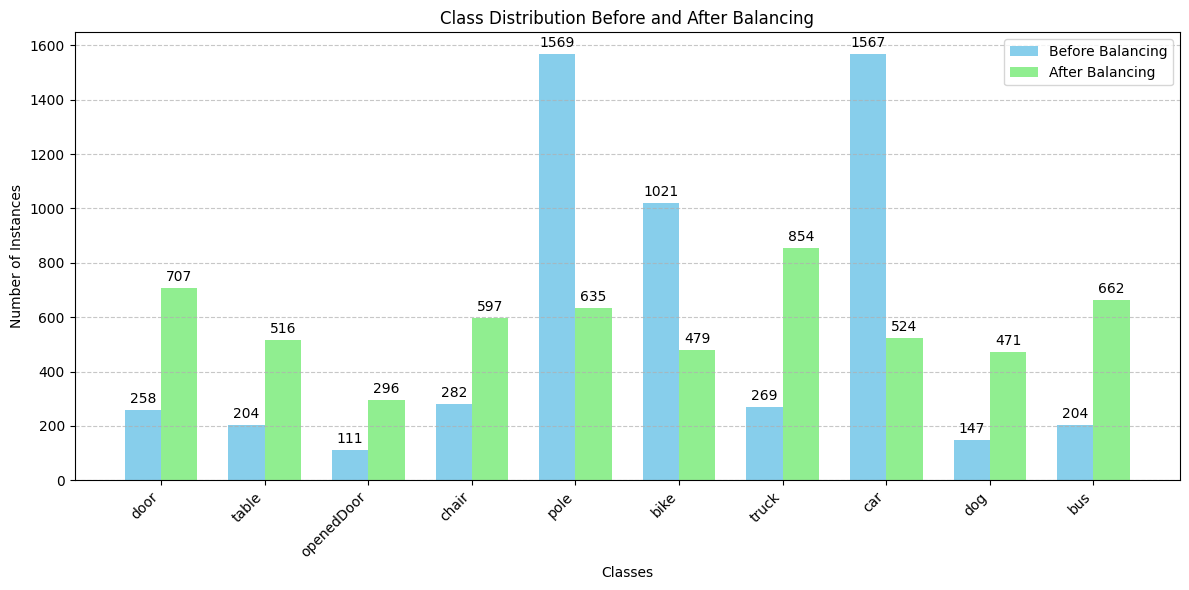

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from pathlib import Path

# Define the selected classes
selected_classes = ['door', 'table', 'openedDoor', 'chair', 'pole', 'bike', 'truck', 'car', 'dog', 'bus']

# Function to count class instances in label files
def get_class_counts(labels_dir):
    counts = Counter()
    for label_file in labels_dir.glob('*.txt'):
        with open(label_file, 'r') as f:
            for line in f:
                if line.strip():
                    class_id = int(float(line.split()[0]))
                    counts[class_id] += 1
    return counts

# Define directory paths
base_dir = Path('../datasets').resolve()
subset_labels_dir = base_dir / 'subset_dataset2' / 'labels'  # Before balancing
balanced_labels_dir = base_dir / 'balanced_subset2' / 'labels'  # After balancing

# Calculate class counts
counts_before = get_class_counts(subset_labels_dir)
counts_after = get_class_counts(balanced_labels_dir)

# Prepare data for plotting
before_values = [counts_before.get(i, 0) for i in range(len(selected_classes))]
after_values = [counts_after.get(i, 0) for i in range(len(selected_classes))]

# Set up the bar plot
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(selected_classes))

# Plot bars for before and after balancing
bar1 = ax.bar(x - bar_width/2, before_values, bar_width, label='Before Balancing', color='skyblue')
bar2 = ax.bar(x + bar_width/2, after_values, bar_width, label='After Balancing', color='lightgreen')

# Function to add value labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to both sets of bars
add_labels(bar1)
add_labels(bar2)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(selected_classes, rotation=45, ha='right')
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Instances')
ax.set_title('Class Distribution Before and After Balancing')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()